In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams['figure.dpi'] = 2.5 * matplotlib.rcParams['figure.dpi']

import numpy as np
import scipy.linalg as sl
import math, sys, os, glob, h5py

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

In [2]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

#plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}',r'\usepackage{amsbsy}',
                                r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5)}
plt.rcParams.update(params)

In [3]:
import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import parameter

import enterprise_extensions
from enterprise_extensions import models, model_utils, frequentist

In [4]:
class OptimalStatistic(object):
    """
    Class for the Optimal Statistic as used in the analysis paper.

    This class can be used for both standard ML or noise-marginalized OS.

    :param psrs: List of `enterprise` Pulsar instances.
    :param bayesephem: Include BayesEphem model. Default=True
    :param gamma_common:
        Fixed common red process spectral index value. By default we
        vary the spectral index over the range [0, 7].
    :param orf:
        String representing which overlap reduction function to use.
        By default we do not use any spatial correlations. Permitted
        values are ['hd', 'dipole', 'monopole'].

    """

    def __init__(self, psrs, psd='powerlaw', gamma_common=4.333, components=30,
                 logf=False, fmin=None, fmax=None, orf='hd', select=None):
        
        # timing model
        s = gp_signals.TimingModel(use_svd=True)
        
        # find the maximum time span to set GW frequency sampling
        self.Tspan = model_utils.get_tspan(psrs)

        # red noise
        s += models.red_noise_block(psd='powerlaw', prior='log-uniform', 
                                    Tspan=self.Tspan, components=components)

        # common red noise block
        if psd == 'powerlaw':
            s += models.common_red_noise_block(psd='powerlaw', prior='log-uniform', 
                                               Tspan=self.Tspan, components=components, 
                                               gamma_val=gamma_common, name='gw')
        elif psd == 'spectrum':
            s += models.common_red_noise_block(psd='spectrum', prior='log-uniform', 
                                        Tspan=self.Tspan, components=components, 
                                        name='gw')

        
        # white noise
        efac = parameter.Constant(1.0)
        ef = white_signals.MeasurementNoise(efac=efac)
        s += ef
        
        self.pta = signal_base.PTA([s(p) for p in psrs])

        # get frequencies here
        self.freqs = self._get_freqs()

        # get F-matrices and set up cache
        self.Fmats = self.get_Fmats()
        self._set_cache_parameters()

        # pulsar locations
        self.psrlocs = [p.pos for p in psrs]

        # overlap reduction function
        if orf == 'hd':
            self.orf = utils.hd_orf
        elif orf == 'dipole':
            self.orf = utils.dipole_orf
        elif orf == 'monopole':
            self.orf = utils.monopole_orf
        else:
            raise ValueError('Unknown ORF!')

    def compute_os(self, params=None, psd='powerlaw', gwfreq=None):
        """
        Computes the optimal statistic values given an
        `enterprise` parameter dictionary.

        :param params: `enterprise` parameter dictionary.

        :returns:
            xi: angular separation [rad] for each pulsar pair
            rho: correlation coefficient for each pulsar pair
            sig: 1-sigma uncertainty on correlation coefficient for each pulsar pair.
            OS: Optimal statistic value (units of A_gw^2)
            OS_sig: 1-sigma uncertainty on OS

        .. note:: SNR is computed as OS / OS_sig.

        """

        # get matrix products
        TNrs = self.get_TNr(params=params)
        TNTs = self.get_TNT(params=params)
        FNrs = self.get_FNr(params=params)
        FNFs = self.get_FNF(params=params)
        FNTs = self.get_FNT(params=params)

        phiinvs = self.pta.get_phiinv(params, logdet=False)

        X, Z = [], []
        for TNr, TNT, FNr, FNF, FNT, phiinv in zip(TNrs, TNTs, FNrs, FNFs, FNTs, phiinvs):
            Sigma = TNT + np.diag(phiinv)

            cf = sl.cho_factor(Sigma)
            SigmaTNr = sl.cho_solve(cf, TNr)
            SigmaTNF = sl.cho_solve(cf, FNT.T)
            FNTSigmaTNr = np.dot(FNT, SigmaTNr)

            X.append(FNr - FNTSigmaTNr)
            Z.append(FNF - np.dot(FNT, SigmaTNF))

        npsr = len(self.pta._signalcollections)
        rho, sig, ORF, xi = [], [], [], []
        for ii in range(npsr):
            for jj in range(ii+1, npsr):
                if psd == 'powerlaw':
                    phiIJ = utils.powerlaw(self.freqs, log10_A=0, gamma=13/3)
                elif psd == 'spectrum':
                    Sf = -np.inf * np.ones(int(len(self.freqs)/2))
                    idx = (np.abs(np.unique(self.freqs) - gwfreq)).argmin()
                    Sf[idx] = 0.0
                    phiIJ = models.free_spectrum(self.freqs, 
                                                 log10_rho=Sf)

                top = np.dot(X[ii], phiIJ * X[jj])
                bot = np.trace(np.dot(Z[ii]*phiIJ[None,:], Z[jj]*phiIJ[None,:]))

                # cross correlation and uncertainty
                rho.append(top / bot)
                sig.append(1 / np.sqrt(bot))

                # Overlap reduction function for PSRs ii, jj
                ORF.append(self.orf(self.psrlocs[ii], self.psrlocs[jj]))

                # angular separation
                xi.append(np.arccos(np.dot(self.psrlocs[ii], self.psrlocs[jj])))

        rho = np.array(rho)
        sig = np.array(sig)
        ORF = np.array(ORF)
        xi = np.array(xi)
        OS = (np.sum(rho*ORF / sig ** 2) / np.sum(ORF ** 2 / sig ** 2))
        OS_sig = 1 / np.sqrt(np.sum(ORF ** 2 / sig ** 2))

        return xi, rho, sig, OS, OS_sig

    def get_Fmats(self, params={}):
        """Kind of a hack to get F-matrices"""
        Fmats = []
        for sc in self.pta._signalcollections:
            ind = []
            for signal, idx in sc._idx.items():
                if signal.signal_name == 'red noise':
                    ind.append(idx)
            ix = np.unique(np.concatenate(ind))
            Fmats.append(sc.get_basis(params=params)[:, ix])

        return Fmats

    def _get_freqs(self):
        """ Hackish way to get frequency vector."""
        for sig in self.pta._signalcollections[0]._signals:
            if sig.signal_name == 'red noise':
                sig._construct_basis()
                freqs = np.array(sig._labels.values()[0])
                break
        return freqs

    def _set_cache_parameters(self):
        """ Set cache parameters for efficiency. """
        self.white_params = []
        self.basis_params = []
        self.delay_params = []

        for sc in self.pta._signalcollections:
            self.white_params.extend(sc.white_params)
            self.basis_params.extend(sc.basis_params)
            self.delay_params.extend(sc.delay_params)

    def get_TNr(self, params={}):
        return self.pta.get_TNr(params=params)

    @signal_base.cache_call(['white_params', 'delay_params'])
    def get_FNr(self, params={}):
        FNrs = []
        for ct, sc in enumerate(self.pta._signalcollections):
            N = sc.get_ndiag(params=params)
            F = self.Fmats[ct]
            res = sc.get_detres(params=params)
            FNrs.append(N.solve(res, left_array=F))
        return FNrs

    @signal_base.cache_call(['white_params'])
    def get_FNF(self, params={}):
        FNFs = []
        for ct, sc in enumerate(self.pta._signalcollections):
            N = sc.get_ndiag(params=params)
            F = self.Fmats[ct]
            FNFs.append(N.solve(F, left_array=F))
        return FNFs

    def get_TNT(self, params={}):
        return self.pta.get_TNT(params=params)

    @signal_base.cache_call(['white_params', 'basis_params'])
    def get_FNT(self, params={}):
        FNTs = []
        for ct, sc in enumerate(self.pta._signalcollections):
            N = sc.get_ndiag(params=params)
            F = self.Fmats[ct]
            T = sc.get_basis(params=params)
            FNTs.append(N.solve(T, left_array=F))
        return FNTs

## IPTA Open 1 MDC files

In [5]:
parfiles = sorted(glob.glob('/Users/staylor/Research/ipta_data/ipta_mdc/IPTA_Challenge1_open/Challenge_Data/Dataset1/*.par'))
timfiles = sorted(glob.glob('/Users/staylor/Research/ipta_data/ipta_mdc/IPTA_Challenge1_open/Challenge_Data/Dataset1/*.tim'))

In [6]:
psrs = []
for ii,data in enumerate(zip(parfiles, timfiles)):
    psrs.append(Pulsar(data[0], data[1], ephem='DE436'))

## Testing OS on dataset

In [7]:
params = {}
params.update({'gw_gamma': 4.33})
params.update({'gw_log10_A': -13.301})

In [8]:
test = OptimalStatistic(psrs=psrs, gamma_common=4.333, orf='hd')

In [9]:
xi, rho, sig, os, os_sig = test.compute_os(params=params)

<Container object of 3 artists>

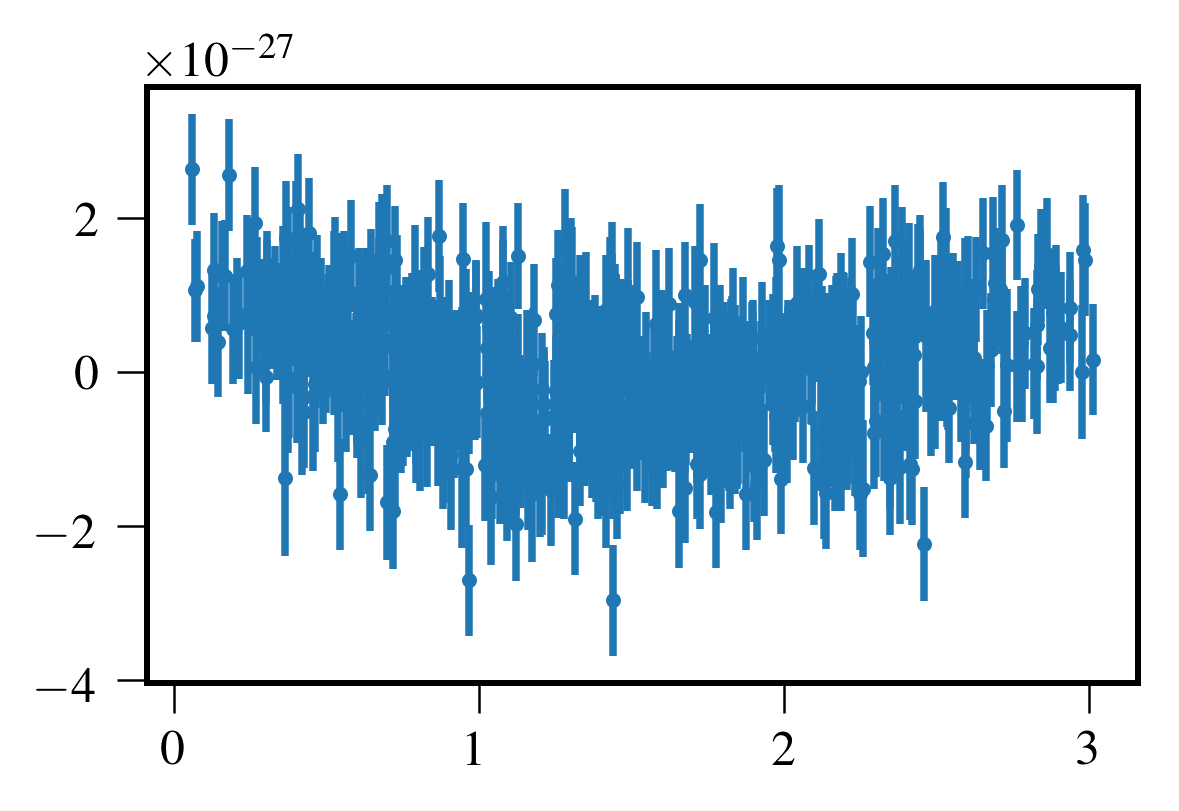

In [10]:
plt.errorbar(xi, rho, sig, fmt='.')

### Theoretical expected SNR

In [11]:
25e-28 / os_sig

13.710668540631785

### Measured SNR

In [12]:
os / os_sig

13.287344730492638

## Investigate scaling of expected SNR with GWB amplitude

In [13]:
Agwb = np.linspace(-16.0, -13.0, 10)
snr = np.zeros_like(Agwb)
for ii,Amp in enumerate(Agwb):
    #
    params = {}
    params.update({'gw_gamma': 4.333})
    params.update({'gw_log10_A': Amp})
    #
    xi, rho, sig, os, os_sig = test.compute_os(params=params)
    #
    snr[ii] = 10.0**(2.0*Amp) / os_sig

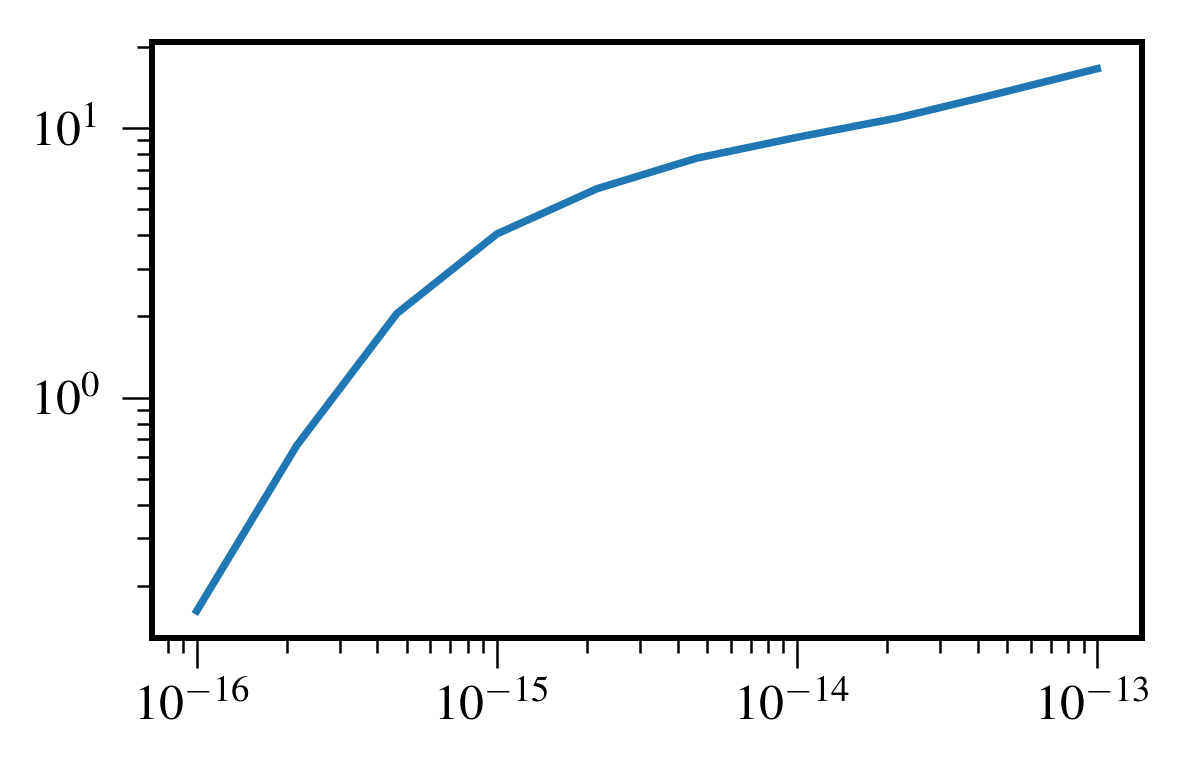

In [14]:
plt.loglog(10.0**Agwb, snr);

In [15]:
Agwb_min = np.interp(np.log10(3.0), np.log10(snr), Agwb)
Agwb_min

-15.146966657721565

## Trying free-spectral OS

In [16]:
components = 30
test = OptimalStatistic(psrs=psrs, psd='spectrum', 
                        orf='hd', components=components)

In [36]:
gwfreqs = np.linspace(1.0,30.0,components) / test.Tspan
hc = np.linspace(-16.0, -13.0, 10)
snr = np.zeros((components, len(hc)))

for ii in range(len(gwfreqs)):
    gwfreq = gwfreqs[ii]
    print ii,gwfreq
    for jj,hc_i in enumerate(hc):
        #
        df = np.diff(gwfreqs)[0]
        Sf_i = 10.0**(2.0*hc_i) / 12.0 / np.pi**2.0 / gwfreq**3.0 * df
        Sf = -np.inf * np.ones(len(gwfreqs))
        Sf[ii] = 0.5 * np.log10(Sf_i)
        #
        params = {}
        params.update({'gw_log10_rho': Sf})
        for p in psrs:
            params.update({p.name+'_red_noise_gamma': 2.0})
            params.update({p.name+'_red_noise_log10_A': -14.0})
        #
        xi, rho, sig, os, os_sig = test.compute_os(params=params, 
                                                   psd='spectrum', 
                                                   gwfreq=gwfreq)
        #
        snr[ii,jj] = Sf_i / os_sig

0 6.408640469e-09
1 1.2817280938e-08
2 1.9225921407e-08
3 2.5634561876e-08
4 3.2043202345e-08
5 3.8451842814e-08
6 4.4860483283e-08
7 5.1269123752e-08
8 5.7677764221e-08
9 6.408640469e-08
10 7.0495045159e-08
11 7.6903685628e-08
12 8.3312326097e-08
13 8.9720966566e-08
14 9.6129607035e-08
15 1.02538247504e-07
16 1.08946887973e-07
17 1.15355528442e-07
18 1.21764168911e-07
19 1.2817280938e-07
20 1.34581449849e-07
21 1.40990090318e-07
22 1.47398730787e-07
23 1.53807371256e-07
24 1.60216011725e-07
25 1.66624652194e-07
26 1.73033292663e-07
27 1.79441933132e-07
28 1.85850573601e-07
29 1.9225921407e-07


In [37]:
hc_min = np.zeros(30)
snr_thr = 3.0

for ii in range(30):
    hc_min[ii] = np.interp(np.log10(snr_thr), np.log10(snr[ii,:]), hc)

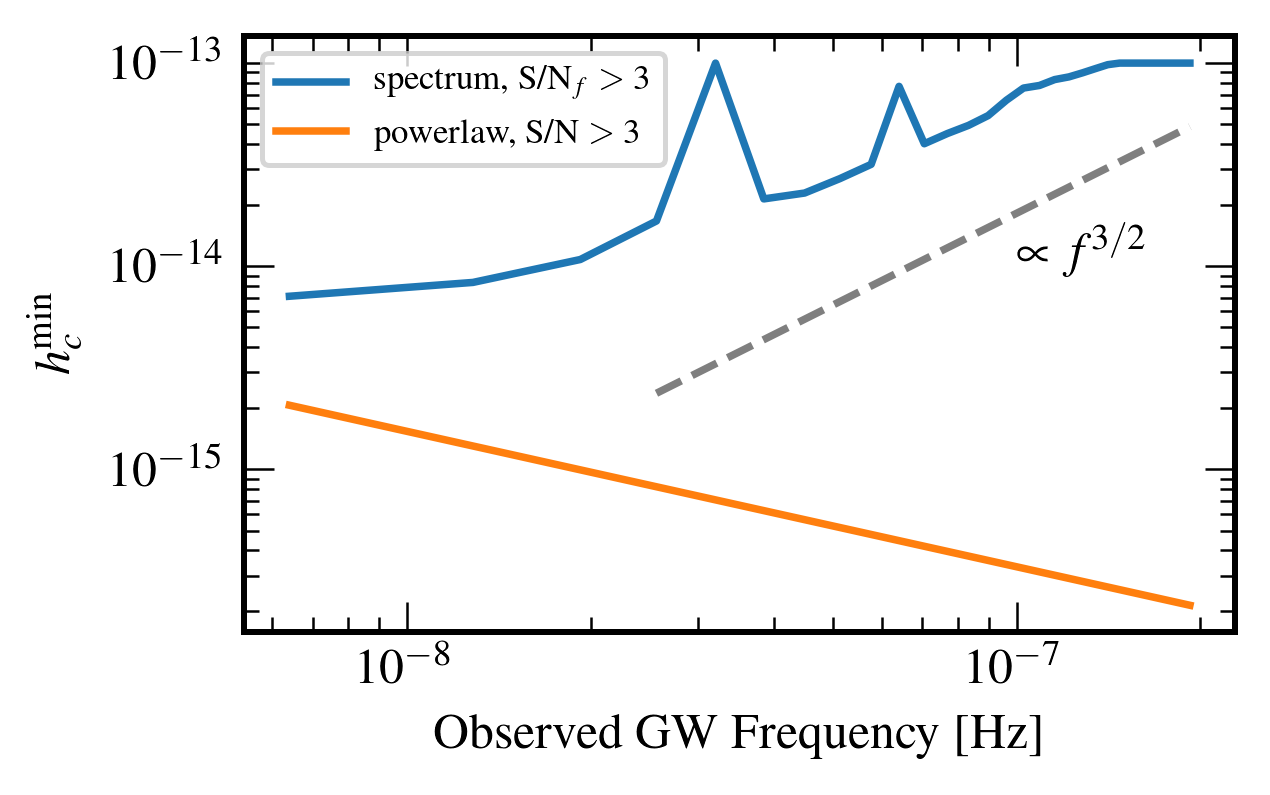

In [38]:
plt.loglog(gwfreqs, 10.0**hc_min, label='spectrum, S/N$_f$ $> 3$')
plt.loglog(np.linspace(4.0,30.0,20) / test.Tspan, 
           3e-15 * (np.linspace(4.0,30.0,20) / test.Tspan / 3e-8)**(3./2.),
          color='k', alpha=0.5, ls='dashed')
plt.text(1e-7, 1e-14, r'$\propto f^{3/2}$')

plt.loglog(gwfreqs, 
           10.0**Agwb_min * (gwfreqs * 365.25 * 86400.0)**(-2./3.),
          label='powerlaw, S/N $> 3$')

plt.xlabel('Observed GW Frequency [Hz]')
plt.ylabel('$h_c^\mathrm{min}$')

plt.minorticks_on()
plt.tick_params(which='both',direction='in',tick2On=True)

plt.legend()

# plt.savefig('os_spectral_sensitivity.pdf',bbox_inches='tight',dpi=400)